<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 14: ускорение тренировки и применения сетей
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

В рамках семинара разберемся в основных проблемах с производительностью, посмотрим, как учить сети на нескольких GPU и научимся квантовать сети.

Для выполнения работы нужны следующие пакеты (Python 3):
* wget
* tarfile
* opencv-python
* pytorch_lightning
* torch
* torchvision

Установить их можно командой:
```bash
pip3 install --user wget tarfile opencv-python pytorch_lightning torch torchvision
```

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import inspect
import os
import random

import cv2
import pytorch_lightning as pl
import tarfile
import torch
import torchvision
import numpy as np
import wget
from matplotlib import pyplot as plt
from tqdm import tqdm

import seminar

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA on", torch.cuda.get_device_name(0))

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Torch 1.5.0
Use CUDA on GeForce RTX 2080 Ti


Настройки

In [2]:
DATASET = "imagenetv2-matched-frequency"
DATA_URL = "https://s3-us-west-2.amazonaws.com/imagenetv2public/{}.tar.gz".format(DATASET)

BATCH_SIZE = 32
NUM_WORKERS = 4

# Загрузка данных

In [28]:
if not os.path.isdir(DATASET):
    print("Download {}".format(DATA_URL))
    filename = wget.download(DATA_URL, out="{}.tar".format(DATASET))
    print("Extract {}".format(filename))
    with tarfile.open(filename) as fp:
        fp.extractall()
    print("Done")
else:
    print("Use cached data")

_ = torchvision.models.resnet101(pretrained=True)

Use cached data


# Создание корпуса

Total dataset size: 10000
Used dataset size: 1000


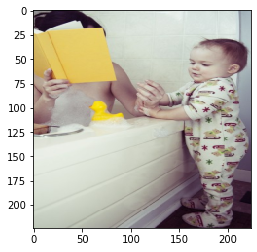

In [10]:
info_dataset = seminar.ImageNetDataset("imagenetv2-matched-frequency")
print("Total dataset size: {}".format(len(info_dataset)))

dataset = seminar.ImageNetDataset("imagenetv2-matched-frequency", num_samples=1000, to_tensor=True)
print("Used dataset size: {}".format(len(dataset)))

dataset_large = seminar.ImageNetDataset("imagenetv2-matched-frequency", to_tensor=True)

dataset_fp16 = seminar.ImageNetDataset("imagenetv2-matched-frequency",
                                       num_samples=1000, to_tensor=True, fp16=True)

image, label = info_dataset[random.randrange(0, len(info_dataset))]
plt.imshow(image)
plt.show()

# Создание модели

In [6]:
model = torchvision.models.resnet101(pretrained=True)
if USE_CUDA:
    model.cuda()
seminar.model_info(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Простые способы ускорения вывода (inference)

### Dataloader со стандартными настройками

In [7]:
dataloader = torch.utils.data.DataLoader(dataset)
seminar.eval_model(model, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.60it/s]

Speed: 17.995 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


### Увеличим размер batch-а
За счет праллелизма большой batch обрабатывается быстрее нескольких маленьких.

In [9]:
print("Batch size:", BATCH_SIZE)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE)
seminar.eval_model(model, dataloader)

  0%|                                                                                                                                                                             | 0/32 [00:00<?, ?it/s]

Batch size: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.14it/s]

Speed: 7.730 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


### Увеличим число процессов подготовки данных
Изначально данные загружались и форматировались в том же процессе, что и тренировка. Во время подготовки данных, нейронная сеть простаивала. Теперь данные будут готовиться в других процессах параллельно с применением сети.

In [10]:
print("NUM_WORKERS:", NUM_WORKERS)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS)
seminar.eval_model(model, dataloader)

  0%|                                                                                                                                                                             | 0/32 [00:00<?, ?it/s]

NUM_WORKERS: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.20it/s]

Speed: 2.864 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


### Включим привязку памяти (page-locked memory aka "pinned" memory)
http://www.orangeowlsolutions.com/archives/443

В оперативной памяти резервируется область, куда кладутся данные для обработки. При этом не используется механизм виртуальной памяти, что ускоряет обмен данными между CPU и GPU.

In [17]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.40it/s]

Speed: 2.589 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


### Воспользуемся половинной точностью (half precision, FP16)
Некоторые GPU поддерживают быстрые вычисления в половинной точности. Можно конертировать веса модели и данные во float16 перед применением. При этом качество предсказаний может измениться.

FP16 позволяет также увеличить размер batch-а.

In [7]:
model_fp16 = torchvision.models.resnet101(pretrained=True)
model_fp16 = model_fp16.half()
if USE_CUDA:
    model_fp16.cuda()

In [13]:
dataloader = torch.utils.data.DataLoader(dataset_fp16,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model_fp16, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.95it/s]

Speed: 3.580 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


С fp16 вывод даже замедлился. Реализация FP16 в PyTorch не полностью использует возможности GPU и создана для ускорения обучения.

# Простые способы ускорения тренировки

Для тренировки будем использовать PyTorch Lightning - библиотеку, реализующую цикл тренировки.

<img style="float: center;" src="resources/lightning.png">

In [8]:
# Estimator вынесен в модуль для правильной работы pickle в распределенной тренировке.
from IPython.display import display, Code
display(Code(inspect.getsource(seminar.Estimator), language="python3"))

class Estimator(pl.LightningModule):
    """Модуль, объединяющий модель, данные и оптимизацию."""
    def __init__(self, model, dataset, batch_size, num_workers):
        super().__init__()
        self._model = model
        self._dataset = dataset
        self._batch_size = batch_size
        self._num_workers = num_workers
        self._loss = torch.nn.CrossEntropyLoss()
        self._start_time = None
        self._num_samples = 0

    def forward(self, images):
        """Применение модели."""
        return self._model(images)
    
    @pl.data_loader
    def train_dataloader(self):
        """Создать загрузчик данных."""
        return torch.utils.data.DataLoader(self._dataset,
                                           batch_size=self._batch_size,
                                           num_workers=self._num_workers,
                                           pin_memory=USE_CUDA)
    
    def training_step(self, batch, batch_idx, optimizer_idx=None):
        """Подсчитать loss для порции данных."""
        if self._start_time is None:
            self._start_time = time.time()
        images, labels = batch
        result = self.forward(images)
        loss = self._loss(result, labels)
        self._num_samples += len(images)
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        """После эпохи выводим оценку производительности."""
        end_time = time.time()
        print("Speed: {:.3f} ms per sample (total {} samples)".format(
            1000 * (end_time - self._start_time) / self._num_samples,
            self._num_samples))
        self._start_time = None
        self._num_samples = 0
        # Dummy implementation.
        return outputs[0]
    
    def configure_optimizers(self):
        """Создаем оптимизатор."""
        return torch.optim.Adam(self._model.parameters(), lr=0.001)

### FP32

In [9]:
estimator = seminar.Estimator(model, dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
trainer = pl.Trainer(max_epochs=1,
                     gpus="0" if USE_CUDA else None)
trainer.fit(estimator)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                         | Type              | Params
---------------------------------------------------------------
0   | _model                       | ResNet            | 44 M  
1   | _model.conv1                 | Conv2d            | 9 K   
2   | _model.bn1                   | BatchNorm2d       | 128   
3   | _model.relu                  | ReLU              | 0     
4   | _model.maxpool               | MaxPool2d         | 0     
5   | _model.layer1                | Sequential        | 215 K 
6   | _model.layer1.0              | Bottleneck        | 75 K  
7   | _model.layer1.0.conv1        | Conv2d            | 4 K   
8   | _model.layer1.0.bn1          | BatchNorm2d       | 128   
9   | _model.layer1.0.conv2        | Conv2d            | 36 K  
10  | _model.layer1.0.bn2          | BatchNorm2d       | 128   
11  | _model.layer1.0.conv3        | Conv2d         

Speed: 7.927 ms per sample (total 1000 samples)


/home/ivan.karpukhin/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


1

### FP16

In [12]:
estimator = seminar.Estimator(model_fp16, dataset_fp16, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
trainer = pl.Trainer(max_epochs=1,
                     gpus="0" if USE_CUDA else None,
                     precision=16,
                     use_amp=False)
trainer.fit(estimator)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                         | Type              | Params
---------------------------------------------------------------
0   | _model                       | ResNet            | 44 M  
1   | _model.conv1                 | Conv2d            | 9 K   
2   | _model.bn1                   | BatchNorm2d       | 128   
3   | _model.relu                  | ReLU              | 0     
4   | _model.maxpool               | MaxPool2d         | 0     
5   | _model.layer1                | Sequential        | 215 K 
6   | _model.layer1.0              | Bottleneck        | 75 K  
7   | _model.layer1.0.conv1        | Conv2d            | 4 K   
8   | _model.layer1.0.bn1          | BatchNorm2d       | 128   
9   | _model.layer1.0.conv2        | Conv2d            | 36 K  
10  | _model.layer1.0.bn2          | BatchNorm2d       | 128   
11  | _model.layer1.0.conv3        | Conv2d         

Speed: 5.264 ms per sample (total 1000 samples)



1

Тренировка ускоряется (при наличии подходящей GPU) примерно на 30%.

Алгоритм Карацубы позволяет умножать fp16 в 3 раза быстрее, чем fp32:
https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%9A%D0%B0%D1%80%D0%B0%D1%86%D1%83%D0%B1%D1%8B

Опять, реализация FP16 в PyTorch не полностью использует возможности GPU.

Использование NVIDIA APEX (флаг use_amp) может повысить производительность.

## Использование нескольких GPU

In [14]:
TRAIN_BATCH_SIZE = 32
estimator = seminar.Estimator(model_fp16, dataset_fp16, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS)
trainer = pl.Trainer(max_epochs=1,
                     gpus="0,1" if USE_CUDA else None,
                     precision=16,
                     use_amp=False,
                     distributed_backend="ddp")
trainer.fit(estimator)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0,1]


1

Из логов Jupyter:

\# Speed: 6.543 ms per sample (total 500 samples)

\# Speed: 6.503 ms per sample (total 500 samples)

Время обработки семпла немного выросло, но каждый процесс обрабатывает только половину корпуса.

# Квантование Int8

In [18]:
def as_int8(X):
    """Важно: clip, round."""
    return np.around(X.clip(-128, 127)).astype(np.int8)

def mul_int8(A, X, scale_prod):
    """Умножить матрицы используя целые числа.
    
    Умножение матриц сводится к скалярному произведению строк и столбцов.
    Скалярное произведение выражается через сумму a1 b1 + a2 b2 + ... + ak bk.
    Из-за умножения и суммирования масштаб результата может сильно отличаться
    от масштаба входных данных. Поэтому:
    1. суммируем в int32,
    2. масштабируем результат перед int8 на выходе.
    """
    Y = A.astype(np.int32) @ X.astype(np.int32).T
    return as_int8(Y * scale_prod)

def eval_quantization(A, X, scale_A, scale_X, scale_prod, verbose=True):
    """Подсчитать L2 ошибку между правильным ответом и квантованным."""
    Y_gt = A @ X.T
    A8 = as_int8(scale_A * A)
    X8 = as_int8(scale_X * X)
    Y8 = mul_int8(A8, X8, scale_prod)
    Y = Y8.astype(np.float32) / scale_prod / scale_A / scale_X
    l2 = np.linalg.norm(Y - Y_gt)
    if verbose:
        print("Scale A:", scale_A)
        print("Scale X:", scale_X)
        print("Scale prod:", scale_prod)
        print("L2:", l2)
    return l2

Создадим данные для экспериментов. Для простоты сэмплируем из нормального распределения.

In [19]:
STD_A = 5
STD_X = 3

A = np.random.randn(20, 10) * STD_A
X = np.random.randn(5000, 10) * STD_X

Квантование без масштабирования:

In [21]:
eval_quantization(A, X, 1, 1, 1)

Scale A: 1
Scale X: 1
Scale prod: 1
L2: 1802.3089451482597


1802.3089451482597

Самая простая стратегия: отмасштабировать так, чтобы min и max попадали в интервал квантования.

In [22]:
max_A = np.max(np.abs(A))
max_X = np.max(np.abs(X))
eval_quantization(A, X, 127 / max_A, 127 / max_X, 3 / 127 / A.shape[1])

Scale A: 9.548793500851788
Scale X: 8.724712869562783
Scale prod: 0.002362204724409449
L2: 497.7759435069582


497.7759435069582

Можно воспользоваться нормальностью значений A и X.

A ~ N(0, VarA)

X ~ N(0, VarX)

A1 X1 + A2 X2 + ... + Ak Xk ~ N(0, k VarA VarX)

Приведем A, X и результат скалярного произведения к фиксированному STD. Величину STD придется подбирать.

In [35]:
STD = 127 / 4.5
k = A.shape[1]
eval_quantization(A, X, STD / np.std(A), STD / np.std(X), 1 / STD / np.sqrt(k))

Scale A: 5.910299475436464
Scale X: 9.420786888206433
Scale prod: 0.011204920843116304
L2: 265.76001809232395


265.76001809232395

Воспользуемся полным перебором:

In [24]:
best = None
best_val = 1e9
for a_scale in tqdm(np.linspace(1, 19, 10)):
    for x_scale in np.linspace(1, 19, 10):
        for prod_scale in np.linspace(0.001, 0.01, 10):
            l2 = eval_quantization(A, X, a_scale, x_scale, prod_scale, verbose=False)
            if l2 < best_val:
                best_val = l2
                best = (a_scale, x_scale, prod_scale)
eval_quantization(A, X, *best)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]

Scale A: 9.0
Scale X: 11.0
Scale prod: 0.006
L2: 247.68541374885285


247.68541374885285

Хорошие результаты получаются при достижении max_entropy (подход TensorRT).

# Квантование TensorRT

TensorRT оптимизирует и квантует сети для GPU. Для квантования на CPU есть OpenVINO.

<img style="float: center;" src="resources/tensorrt.png">

In [7]:
import tensorrt as trt
import torch2trt

MAX_BATCH_SIZE = 512

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=32,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=USE_CUDA,
                                         shuffle=True)
batch = next(iter(dataloader))[0].cuda()

Повторим замеры без TensorRT.

In [39]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.63it/s]

Speed: 2.540 ms per sample
Top 1 accuracy: 0.002
Top 5 accuracy: 0.021


### FP32

In [40]:
if False:
    model_trt = torch2trt.torch2trt(model, [batch], max_batch_size=MAX_BATCH_SIZE, log_level=trt.Logger.INFO)
    torch.save(model_trt.state_dict(), "trt32.pth.tar")
else:
    model_trt = torch2trt.TRTModule()
    model_trt.load_state_dict(torch.load("trt32.pth.tar"))

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model_trt, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 15.37it/s]

Speed: 2.086 ms per sample
Top 1 accuracy: 0.624
Top 5 accuracy: 0.830


### FP16

In [13]:
if False:
    model_trt_fp16 = torch2trt.torch2trt(model, [batch],
                                         fp16_mode=True,
                                         max_batch_size=MAX_BATCH_SIZE, log_level=trt.Logger.INFO,
                                         strict_type_constraints=True)
    torch.save(model_trt_fp16.state_dict(), "trt16.pth.tar")
else:
    model_trt_fp16 = torch2trt.TRTModule()
    model_trt_fp16.load_state_dict(torch.load("trt16.pth.tar"))

In [27]:
dataloader = torch.utils.data.DataLoader(dataset_large,
                                         batch_size=128,
                                         num_workers=16,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model_trt_fp16, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.57it/s]

Speed: 0.748 ms per sample
Top 1 accuracy: 0.635
Top 5 accuracy: 0.845


### INT8

In [8]:
if False:
    calib_dataset = torch.utils.data.Subset(dataset, random.sample(range(len(dataset)), 50))
    model_trt_int8 = torch2trt.torch2trt(model, [batch],
                                         int8_mode=True,
                                         int8_calib_dataset=calib_dataset,
                                         max_batch_size=MAX_BATCH_SIZE, log_level=trt.Logger.INFO,
                                         strict_type_constraints=True)
    torch.save(model_trt_int8.state_dict(), "trt8.pth.tar")
else:
    model_trt_int8 = torch2trt.TRTModule()
    model_trt_int8.load_state_dict(torch.load("trt8.pth.tar"))

In [26]:
dataloader = torch.utils.data.DataLoader(dataset_large,
                                         batch_size=128,
                                         num_workers=16,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model_trt_int8, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 11.37it/s]

Speed: 0.695 ms per sample
Top 1 accuracy: 0.630
Top 5 accuracy: 0.843


# Quantization aware training

Если качество после int8 квантования оказалось слишком низким, можно пойти одним из двух путей:
1. Квантовать только часть слоев. Лучше квантовать верхние слои, т.к. ошибка накапливается. При этом не стоит квантовать последние 1-2 слоя (fully connected), поскольку они аггрегируют признаки с предыдущих слоев и могут исправлять / сглаживать ошибки.
2. Изменить процедуру обучения так, чтобы модель лучше квантовалась: quantization aware training. Во время forward pass выходы слоев округляются до квантованных значений. Backward pass не изменяется. При этом тренировка по прежнему выполняется во floating point.

Benoit Jacob et al. Quantization and Training of Neural Networks for Efficient Integer-Arithmetic-Only Inference (2017)

https://arxiv.org/abs/1712.05877

PyTorch с версии 1.5 начал поддержку QAT (пока только простые CNN):

https://pytorch.org/docs/stable/quantization.html#id10